# Distribution B - Maximum Likelihood

In [312]:
import DistExampB as db

import cvxpy as cp

from matplotlib import pyplot as plot
from numpy import sinc
from scipy.optimize import fsolve
from sympy import Symbol, lambdify

from LocUtil import Grid1, LogGrid1, MinMax, MinIndex, SetSeed, UnZip
from Map import LogRatio

In [313]:
nSamp = 100

givenSeed = None
seedDig = 3

nPlot = 101
figSize = (9, 6.5)

dist = db.ExampB()

In [314]:
seed = SetSeed(givenSeed, seedDig)
if givenSeed is None:
	print(f'seed = {seed}')

samp = sorted(tuple(dist.Sample() for _ in range(nSamp)))
quant = tuple((k + 0.5) / nSamp for k in range(nSamp))

seed = 300


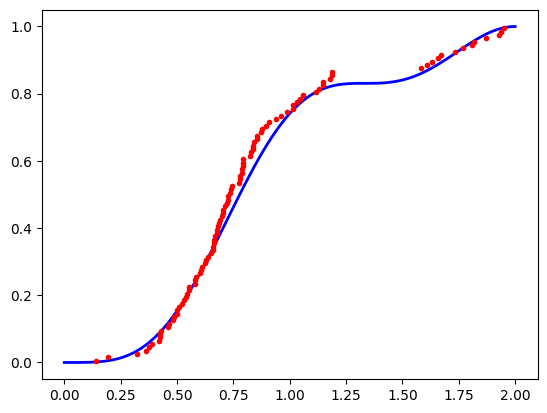

In [315]:
plot.plot(samp,quant, '.', c='red')

xGrid = Grid1(0,2,nPlot)
cdfX = tuple(dist.Cdf(x) for x in xGrid)
plot.plot(xGrid, cdfX, c="blue", lw=2, zorder=-1)

## Change of Variable

In [316]:
xSym = Symbol('x')
zSym = Symbol('z')

map_ = LogRatio(xSym, zSym, (0, 2))

In [317]:
map_.forSym

log(x/(2 - x))

In [318]:
map_.invSym

2*exp(z)/(exp(z) + 1)

In [319]:
sampZ = tuple(map_.Forward(x) for x in samp)

In [320]:
zMin,zMax = MinMax(sampZ)
zMin,zMax

(-2.582800552980196, 3.6805487565671124)

In [321]:
jacobSym = map_.invSym.diff(zSym).simplify().factor()
jacobSym

2*exp(z)/(exp(z) + 1)**2

In [322]:
jacobZ = lambdify(zSym, jacobSym)

## Maximize Log-Likelihood for Sinc Approx of P(z)

In [323]:
nSinc = 11
sincZ = Grid1(zMin,zMax, nSinc)
h = (zMax - zMin) / (nSinc - 1)

In [324]:
nSinc, h

(11, 0.6263349309547308)

In [325]:
sincVal = cp.Variable(nSinc)
sincVal

Variable((11,), var78974)

In [326]:
logLike = lambda z: cp.log(sum(sv * sinc((z - sz) / h) for (sz,sv) in zip(sincZ,sincVal)))
obj = cp.Maximize(sum(logLike(z) * jacobZ(z) for z in sampZ))

In [327]:
constEach = list(0 <= sv for sv in sincVal)
constTotal = h * sum(sv for (sz,sv) in zip(sincZ, sincVal)) == 1
# constTotal = h * sum(sv for (sz,sv) in zip(sincZ, sincVal)) == 1
const = constEach + [constTotal]

In [328]:
prob = cp.Problem(obj,const)
prob.solve()

In [330]:
sincV = list(sincVal.value)

In [331]:
sum(sincV) * h

0.9999999956773561

Check that the integral of the PDF in z is in fact 1

In [332]:
xSplit = fsolve(lambdify(xSym, dist.pdfSym.diff(xSym)), 1.2)[0]
xSplit

1.3333333333333515

In [333]:
zSplit = map_.Forward(xSplit)
zSplit

0.6931471805599861

In [334]:
nLeft = len(tuple(z for z in sampZ if z < zSplit))
probLeft = dist.Cdf(xSplit)

Text(0, 0.5, 'PDF')

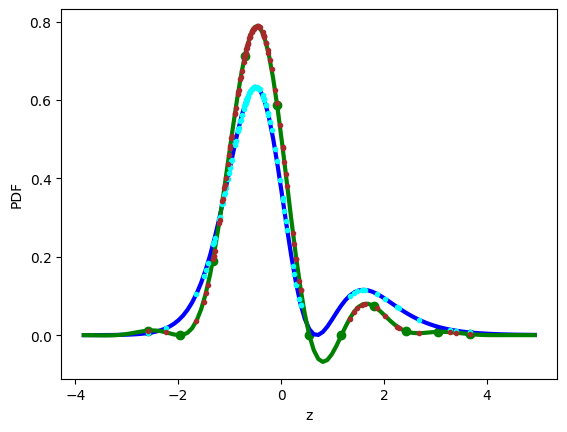

In [335]:
plot.plot(sincZ, sincVal.value, 'o', c='green')

zGrid = Grid1(zMin - 2*h, zMax + 2*h, nPlot)
pdf = tuple(dist.Pdf(map_.Inverse(z)) * jacobSym.subs(zSym,z) for z in zGrid)
plot.plot(zGrid,pdf, c='blue', linewidth=3)

interp = InterpZ1(sincZ,sincV, zGrid)
plot.plot(zGrid,interp, c='green', linewidth=3)

sampPdf = tuple(dist.Pdf(x) * jacobSym.subs(zSym, map_.Forward(x)) for x in samp)
plot.plot(sampZ,sampPdf, '.', c='cyan')

sampEstPdf = InterpZ1(sincZ,sincV, sampZ)
plot.plot(sampZ,sampEstPdf, '.', c='brown')

plot.xlabel('z')
plot.ylabel('PDF')

In [336]:
(nLeft / nSamp, probLeft)

(0.87, 0.8308040150894854)